In [1]:
import nltk
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from collections import defaultdict

In [3]:
from google.colab import drive
drive.mount('/content/drive') # drive google mount

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Dataset Review and exploration**

Load the data and join the datasets together

In [4]:
df1 = pd.read_csv("/content/drive/MyDrive/Thesis/Learning_DataSet/train1.csv", sep=";")
df2 = pd.read_csv("/content/drive/MyDrive/Thesis/Learning_DataSet/train.csv", sep=";")
df3 = pd.read_csv("/content/drive/MyDrive/Thesis/Learning_DataSet/train2.csv", sep=";")

df  = pd.concat([df1, df2, df3])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head(5)

,text,label
0,fake news spread lie reader shrug truth new yo...,1
1,earthling test warn system asteroid fly frankf...,1
2,atf plan send agent chicago curb violence new ...,1
3,bear enjoy sprinklermemorable heartwarming fil...,0
4,republican convention hillary clinton roger ai...,1


Load the testing data

In [5]:
t1 = pd.read_csv("/content/drive/MyDrive/Thesis/Learning_DataSet/test1.csv", sep=";")
t2 = pd.read_csv("/content/drive/MyDrive/Thesis/Learning_DataSet/test.csv", sep=";")
t3 = pd.read_csv("/content/drive/MyDrive/Thesis/Learning_DataSet/test2.csv", sep=";")

test  = pd.concat([t1, t2, t3])
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
df.dropna(inplace = True)
test.dropna(inplace = True)

In [9]:
print("Fake and real from training: ")
print(df['label'].value_counts())
print("Fake and real from testing")
print(test['label'].value_counts())

Fake and real from training: 
label
1    12529
0    12529
Name: count, dtype: int64
Fake and real from testing
label
0    3054
1    3039
Name: count, dtype: int64


In [10]:
df.isna().sum() # sum of none, check if droped all

text     0
label    0
dtype: int64

Countplot of articles, distributed between fake and real classes

<ipython-input-33-c1fd76ee171d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=palette)


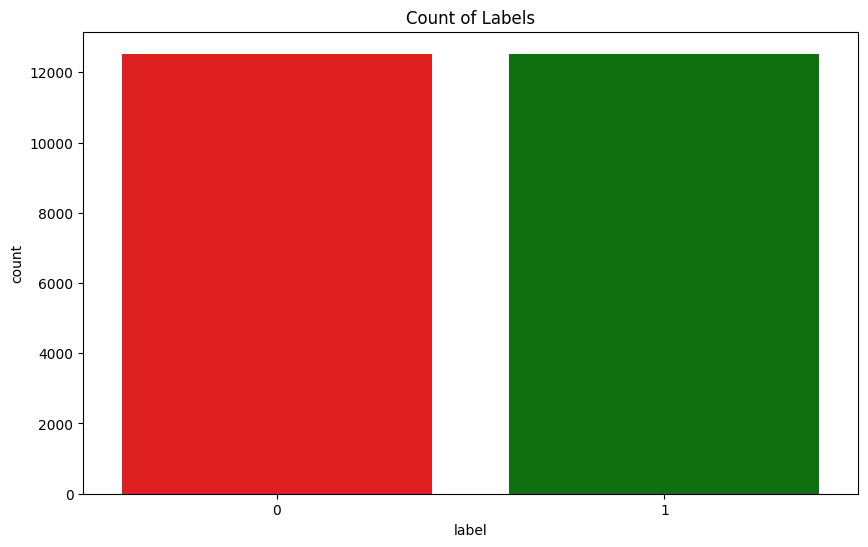

In [33]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure consistent results
np.random.seed(2023)

# Plotting the count of labels
plt.figure(figsize=(10, 6))
palette = {"1": "green", "0": "red"}
sns.countplot(x='label', data=df, palette=palette)
plt.title('Count of Labels')
plt.show()

# Retrieve count data and format it
count_data = df['label'].value_counts().to_dict()
count_data_json = {'Fake': round(count_data[0]), 'Real': round(count_data[1])}

# Save to JSON file
with open('count_plot_data_LR.json', 'w') as json_file:
    json.dump(count_data_json, json_file)


### **Clean the dataset and combine titles and text**

In [14]:
import string
df['text'] = df['text'].astype(str) # turn all text to string

def clean_text_data(text):
  text = str(text)
  text = text.lower()
  to_remove = r'https?://\S+|www\.\S+|<.*?>|\d+|\W+'
  text = re.sub(to_remove, ' ', text)
  return text.strip()

df['text'] = df['text'].apply(clean_text_data)
test['text'] = test['text'].apply(clean_text_data)


In [15]:
print(df['text'].str.len().mean()) # mean lenhght of the string in characters in the dataset

2874.7089951312955


### **Show how articles are distributed with length over each class. This will aid in choosing how long the user input should be.**

<ipython-input-34-86f2d435ee51>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Fake News', 'Real News'], y=[mean_lengths_json['Fake'], mean_lengths_json['Real']], palette={'Fake News': 'red', 'Real News': 'green'})


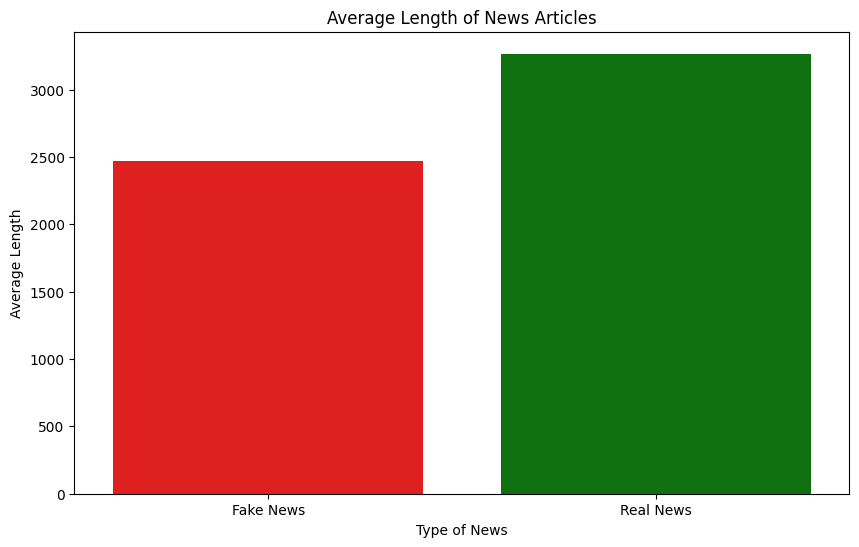

In [34]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df['length'] = df['text'].apply(len)

mean_lengths = df.groupby('label')['length'].mean().to_dict()

# Map labels to 'Fake' and 'Real'
mean_lengths_json = {'Fake': round(mean_lengths[0]), 'Real':round( mean_lengths[1])}

# Plotting the average lengths
plt.figure(figsize=(10, 6))
sns.barplot(x=['Fake News', 'Real News'], y=[mean_lengths_json['Fake'], mean_lengths_json['Real']], palette={'Fake News': 'red', 'Real News': 'green'})
plt.title('Average Length of News Articles')
plt.ylabel('Average Length')
plt.xlabel('Type of News')
plt.show()
# Save for web app
with open('mean_lengths_LR.json', 'w') as file:
    json.dump(mean_lengths_json, file)


In [19]:
print(len(df['text'][0]))

5458


Draw a word cloud, not used in the app, but good to see which words appear the most

In [20]:
import json
from wordcloud import WordCloud
wcText = ' '.join(str(text) for text in df['text'].tolist())
wordcloud = WordCloud(width=1920, height=1080).generate(wcText)

### **Preparing the data for model training by splitting the words and redcue to root word**

In [21]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer as wn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split as tts
from nltk.tokenize import word_tokenize

# remove the stopwords
def remove_stopwords_lemmatize(text):
    lemmatizer = wn()
    tokenized = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    return ' '.join([lemmatizer.lemmatize(w) for w in tokenized if w not in stop_words])


df['text'] = df['text'].apply(remove_stopwords_lemmatize)
test['text'] = test['text'].apply(remove_stopwords_lemmatize)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Vectorize textual data for training so machine can understand

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Define the TfidfVectorizer
#tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.002)
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(df['text'])
y_train = df['label']

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(test['text'])

In [23]:
count_vectorizer = CountVectorizer()

X_count_trian = count_vectorizer.fit_transform(df['text'])
X_count_test = count_vectorizer.transform(test['text'])

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

model = LogisticRegression(C=1, max_iter=100, n_jobs=-1) # tried C < 1
scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy') # score for accuracy, cross validation more valid
print("Cross-Validation Accuracy:", scores.mean())
model.fit(X_train_tfidf, y_train) # Fit the model on the training data

# Evaluate the model on the test data
y_test=test['label']
y_pred = model.predict(X_test_tfidf)
model_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", model_accuracy)

Cross-Validation Accuracy: 0.9356693645886474
Test Accuracy: 0.936812735926473


In [26]:
model2 = LogisticRegression(max_iter=250, C=0.5) # model for count vectorizer
model2.fit(X_count_trian, y_train)
pred2 = model2.predict(X_count_test)
print("Accuracy COUNT:", accuracy_score(y_test, pred2))

Accuracy COUNT: 0.9423929098966026


In [27]:
# using 2-gram values for the tfidf
model_bigram = LogisticRegression(C=0.70) # Choosing C values, smaller value makes model more complex
tfidf_vectorizer_bigram = TfidfVectorizer(ngram_range=(2,2), max_df=0.8, min_df=0.002) # bigram only
X_train_tfidf_bigram = tfidf_vectorizer_bigram.fit_transform(df['text'])

# Transform the test data
X_test_tfidf_bigram = tfidf_vectorizer_bigram.transform(test['text'])
model_bigram.fit(X_train_tfidf_bigram, y_train)
new_pred =model_bigram.predict(X_test_tfidf_bigram)
model_accuracy2 = accuracy_score(y_test, new_pred)
print("Test Accuracy of ngram TFIDF:", model_accuracy2)

Test Accuracy of ngram TFIDF: 0.9312325619563433


Accuracy score is higher for count vectorizer but real life implementation is has better accuracy with TF-**IDF**

*   For the unigram and bigram tuple, the tradeoff between the size and performance is too big, as the model and vectorizer together almost have 150MB



Confusion Matrix:
 [[2898  156]
 [ 229 2810]]


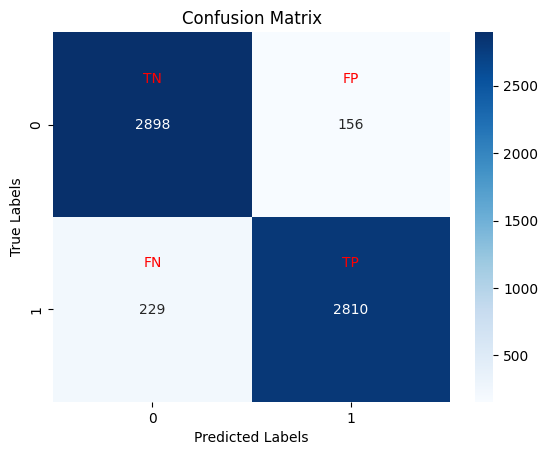

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

labels = ['TN', 'FP', 'FN', 'TP'] # labels for quadrant
label_positions = [(0,0), (0,1), (1,0), (1,1)]
for label, pos in zip(labels, label_positions):
    plt.text(pos[1]+0.5, pos[0]+0.25, label, ha='center', va='center', color='red')

plt.show()


In [37]:
import pickle

# Pickle the trained ensemble model
with open('/content/drive/MyDrive/Thesis/LogisticRegression/touse_latest_LR_second.pkl', 'wb') as f:
    pickle.dump(model, f)

# Pickle the TF-IDF vectorizer
with open('/content/drive/MyDrive/Thesis/LogisticRegression/touse_latest_vect_second.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [45]:
def classify(x):
    if x == 0:
        return "The news are highly likely to be fake."
    elif x == 1:
        return "The news are higly likely to be real."



def verdict(article_text, vect, modela):
    # Preprocess the text
    preprocessed_text = clean_text_data(article_text)
    new_text = remove_stopwords_lemmatize(preprocessed_text)
    transformed_text = vect.transform([preprocessed_text])
    # Predict using the pre-trained model
    prediction = modela.predict(transformed_text)
    # Classify the processed prediction
    classification = classify(prediction)
    print(classification)

In [46]:
article = "Once seen as a likely successor to Iran’s Supreme Leader, President Ebrahim Raisi has died in office, leaving the Islamic Republic’s hardline establishment facing an uncertain future.\
An ultraconservative president, 63-year-old Raisi was killed Sunday, along with Foreign Minister Hossein Amir-Abdollahian and other high-ranking officials, in a helicopter crash in Iran’s remote northwest. Their death comes at a delicate time for a country that faces unprecedented challenges at home and from abroad.\
The Islamic Republic’s economy remains crippled by American sanctions, its young population is becoming growingly restive, and the country faces increasingly belligerent adversaries in the Middle East and beyond.\
Raisi’s death will “trigger elections at a time when the IRI (Islamic Republic of Iran) is at the nadir of its legitimacy and zenith of its exclusionary policies,” Ali Vaez, Iran Project Director at the International Crisis Group think tank, said on X."


verdict(article, tfidf_vectorizer, model)


The news are higly likely to be real.
